In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
from stable_baselines3 import PPO, A2C, SAC, DQN, TD3, DDPG
import matplotlib.pyplot as plt


class JobSchedulingEnv(gym.Env):
    def __init__(self, num_jobs=5):
        super(JobSchedulingEnv, self).__init__()
        self.num_jobs = num_jobs

        # Each job has 6 features:
        # (arrival_time, execution_time, priority, deadline, cpu_requirement, job_type)
        # job_type: 0 for I/O-bound, 1 for CPU-bound
        self.jobs = []
        self.backup_jobs = []

        # Joint action space:
        # First num_jobs dimensions: scheduling scores (continuous in [0,1])
        # Last dimension: resource allocation decision (continuous in [0,1])
        self.action_space = spaces.Box(
            low=0, high=1, shape=(num_jobs + 1,), dtype=np.float32
        )

        # Observation space: Each job is represented by 6 features.
        self.observation_space = spaces.Box(
            low=0, high=100, shape=(num_jobs, 6), dtype=np.float32
        )

        self.reset()

    def reset(self, seed=None, options=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        arrival_times = np.sort(
            np.random.normal(loc=5, scale=2, size=self.num_jobs)
        )  # Clustered arrivals
        arrival_times = np.clip(arrival_times, 0, 10) / 10  # Normalize to [0,1]

        execution_times = (
            np.clip(np.random.normal(loc=5, scale=2, size=self.num_jobs), 1, 10) / 10
        )
        priorities = (
            np.random.choice(
                [1, 2, 3, 4, 5], self.num_jobs, p=[0.1, 0.2, 0.4, 0.2, 0.1]
            )
            / 5
        )
        deadlines = (
            arrival_times
            + execution_times
            + np.random.randint(3, 10, size=self.num_jobs)
        ) / 20
        cpu_requirements = np.random.randint(1, 11, size=self.num_jobs) / 10
        job_types = np.random.choice([0, 1], self.num_jobs)  # I/O or CPU bound

        self.jobs = list(
            zip(
                arrival_times,
                execution_times,
                priorities,
                deadlines,
                cpu_requirements,
                job_types,
            )
        )
        self.jobs.sort(key=lambda x: x[0])
        self.backup_jobs = self.jobs.copy()  # keep a backup for baselines
        self.time = 0  # simulation time
        self.done_jobs = []
        self.total_waiting_time = 0

        return self._get_observation(), {}

    def _get_observation(self):
        obs = np.zeros((self.num_jobs, 6), dtype=np.float32)
        for i, job in enumerate(self.jobs):
            obs[i] = job
        return obs

    # def _get_observation(self):
    #     if len(self.jobs) == 0:
    #         return np.zeros((self.num_jobs, 6), dtype=np.float32)
    #     obs = np.array([job for job in self.jobs], dtype=np.float32)

    #     if len(obs) < self.num_jobs:
    #         padding = np.zeros((self.num_jobs - len(obs), 6), dtype=np.float32)
    #         obs = np.vstack([obs, padding])
    #     return obs
    def step(self, action):
        scheduling_scores = action[: self.num_jobs]
        resource_allocation = action[-1]

        job_index = int(np.argmax(scheduling_scores))

        if job_index >= len(self.jobs):
            return self._get_observation(), -10, True, False, {}

        selected_job = self.jobs.pop(job_index)
        arrival_time, execution_time, priority, deadline, cpu_req, job_type = (
            selected_job
        )

        # Advance simulation time
        self.time = max(self.time, arrival_time) + execution_time

        # Compute waiting time and base reward.
        waiting_time = self.time - arrival_time - execution_time
        self.total_waiting_time += waiting_time
        base_reward = -waiting_time - (execution_time / priority) - len(self.jobs) * 0.1

        # Deadline-based reward adjustment:
        if self.time > deadline:
            base_reward -= 10  # penalty for missing deadline
        else:
            base_reward += 5  # bonus for meeting deadline

        # Energy consumption penalty based on resource allocation decision.
        # Assume an optimal resource allocation value. Deviations incur a penalty.
        optimal_resource = 0.7
        energy_penalty = 5 * abs(resource_allocation - optimal_resource)

        throughput_reward = 10 / (self.time + 1)
        # efficiency_bonus = 5 * (1 - abs(resource_allocation - optimal_resource))

        reward = base_reward + throughput_reward - energy_penalty

        self.done_jobs.append(selected_job)
        done = len(self.jobs) == 0

        return self._get_observation(), reward, done, False, {}


In [2]:
def fifo_scheduling(jobs):
    time = 0
    total_waiting_time = 0
    for job in sorted(jobs, key=lambda x: x[0]):  # sort by arrival_time
        arrival_time, execution_time, priority, deadline = job[:4]
        time = max(time, arrival_time) + execution_time
        total_waiting_time += time - arrival_time - execution_time
    return total_waiting_time


def sjf_scheduling(jobs):
    time = 0
    total_waiting_time = 0
    for job in sorted(jobs, key=lambda x: x[1]):  # sort by execution_time
        arrival_time, execution_time, priority, deadline = job[:4]
        time = max(time, arrival_time) + execution_time
        total_waiting_time += time - arrival_time - execution_time
    return total_waiting_time


def edf_scheduling(jobs):
    time = 0
    total_waiting_time = 0
    for job in sorted(jobs, key=lambda x: x[3]):  # sort by deadline
        arrival_time, execution_time, priority, deadline = job[:4]
        time = max(time, arrival_time) + execution_time
        if time > deadline:
            total_waiting_time += (
                time - deadline
            ) * 2  # heavier penalty for missing deadline
        else:
            total_waiting_time += time - arrival_time - execution_time
    return total_waiting_time


def rr_scheduling(jobs, quantum=1):
    time = 0
    total_waiting_time = 0
    queue = jobs.copy()

    while queue:
        job = queue.pop(0)
        arrival_time, execution_time, priority, deadline = job[:4]

        if time < arrival_time:
            time = arrival_time

        if execution_time > quantum:
            time += quantum
            queue.append((arrival_time, execution_time - quantum, priority, deadline))
        else:
            time += execution_time
            total_waiting_time += time - arrival_time - execution_time

    return total_waiting_time


Output()

Output()

Output()

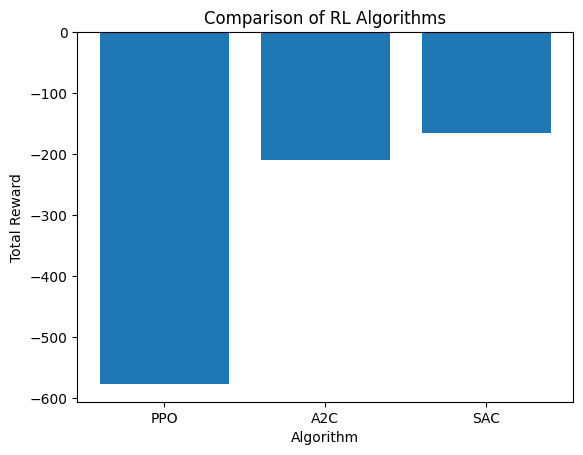

In [ ]:
algos = {"PPO": PPO, "A2C": A2C, "SAC": SAC, "DQN": DQN, "TD3": TD3,  "DDPG": DDPG}
results = {}


env = JobSchedulingEnv(num_jobs=5)

for name, algo in algos.items():
    model = algo("MlpPolicy", env, verbose=0, tensorboard_log="./tb_logs/")
    model.set_random_seed(42)
    model.learn(total_timesteps=5000, progress_bar=True)

    total_reward = 0
    for _ in range(10):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

    results[name] = total_reward

plt.bar(results.keys(), results.values())
plt.xlabel("Algorithm")
plt.ylabel("Total Reward")
plt.title("Comparison of RL Algorithms")
plt.show()


In [4]:
ALGO = "SAC"
POLICY = "MlpPolicy"


env = JobSchedulingEnv(num_jobs=5)

model = algos[ALGO](POLICY, env, verbose=1, tensorboard_log="./tb_logs/")

model.set_random_seed(42)
model.learn(total_timesteps=20000, progress_bar=True)

# obs, _ = env.reset()
# done = False
rewards = []

for _ in range(10):  # Test for 10 episodes
    obs, _ = env.reset()
    done = False
    episode_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
    rewards.append(episode_reward)

print("Average Reward:", np.mean(rewards))
print("Total Waiting Time:", env.total_waiting_time)
print("Done Jobs:", len(env.done_jobs))


Output()

KeyboardInterrupt: 

In [ ]:
rewards_per_episode = []
obs, _ = env.reset()
for _ in range(100):  # 100 test episodes
    action, _ = model.predict(obs)
    obs, reward, done, _, _ = env.step(action)
    rewards_per_episode.append(reward)

plt.plot(rewards_per_episode, label="Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.title("Learning Curve")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(rewards, label="RL Agent Reward per Step")
fifo = -fifo_scheduling(env.jobs)
sjf = -sjf_scheduling(env.jobs)
edf = -edf_scheduling(env.jobs)
plt.axhline(y=fifo, color="r", linestyle="--", label="FIFO Baseline")
plt.axhline(y=sjf, color="g", linestyle="--", label="SJF Baseline")
plt.axhline(y=edf, color="b", linestyle="--", label="EDF Baseline")
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.title("Reward Over Time in Job Scheduling")
plt.legend()
plt.show()


In [ ]:
model.save(f"js_model_{ALGO}.zip")


In [ ]:
loaded_model = algos[ALGO].load(f"js_model_{ALGO}.zip", env=env)
obs, _ = env.reset()
done = False
rewards = []
while not done:
    action, _ = loaded_model.predict(obs)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    rewards.append(reward)
print("Loaded Model Average Reward:", np.mean(rewards))
print("Loaded Model Total Waiting Time:", env.total_waiting_time)
print("Loaded Model Done Jobs:", len(env.done_jobs))